In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from configs import configs
import urllib.parse
sys.path.append('../')

Using TensorFlow backend.


In [2]:
# Load config
config = configs[0]
config['epochs'] = 100
print(config)

{'batch_size': 128, 'epochs': 100, 'image_dimension': 128, 'monitor': 'pr_auc', 'random_initialization': False, 'class_weights': False, 'hierarchical': False, 'loss_function': 'sample_weight', 'number_trainable_layers': 'all', 'data_folder': 'data/split_data_230412', 'results_folder': 'results_paper/230428_flatModel_sample_weight_monitorpr_auc_50epochs'}


In [3]:
train, train_df = hf.get_flow(df_file=config['data_folder'] + '/train_df.json.bz2',
                              batch_size=config['batch_size'],
                              image_dimension=config['image_dimension'])

Found 700000 validated image filenames belonging to 28 classes.


In [19]:
# Load human-labeled set
human_df = pd.read_parquet('../../data/evaluation/annotated_validation.parquet')
human_df['labels'] = human_df.apply(lambda x: list(x.labels), axis=1) # otherwise the labels column will be a list of lists
human_df['url'] = human_df.apply(lambda x: x.url.split('/wikipedia/commons/')[1], axis=1)
human_df['url'] = human_df['url'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))

(42, 6)


,title,id,url,categories,labels,is_valid
21,"Beggar's Box ,1968.jpg",38431270,"d/d5/Beggar's_Box_,1968.jpg",[Art of Catalonia],"[Technology & Engineering, STEM]",False
33,Tabasco Opera 2018 c.jpg,75869283,7/78/Tabasco_Opera_2018_c.jpg,"[Musicals, Tabasco sauce, January 2018 in New ...","[Culture, Events, Music, Society]",False
35,Shankarabharanam scale.svg,5285664,b/b6/Shankarabharanam_scale.svg,[Carnatic ragams (svg)],"[Culture, Music]",False
42,SAS 2.gif,1333491,5/55/SAS_2.gif,[Small Astronomy Satellite 2],"[STEM, Space]",False
87,Stone Arch Bridge Wapsipincon State Park.jpg,60388242,f/ff/Stone_Arch_Bridge_Wapsipincon_State_Park.jpg,[Bridges on the National Register of Historic ...,"[Places, STEM, Landscapes, Nature, Plants]",False
92,Sensornode.svg,7444088,8/8d/Sensornode.svg,"[Computer diagrams, Computer architecture diag...","[Diagrams, STEM]",False
99,Camden County New Jersey Incorporated and Unin...,2971889,2/20/Camden_County_New_Jersey_Incorporated_and...,[Locator maps of populated places in Camden Co...,"[Places, Maps & Flags]",False
111,M-House house divisions.jpg,56977077,c/cd/M-House_house_divisions.jpg,"[Astrological diagrams, House (astrology)]","[Diagrams, STEM]",False
144,Map of New Mexico highlighting Cibola County.svg,572074,d/dd/Map_of_New_Mexico_highlighting_Cibola_Cou...,"[Maps of Cibola County, New Mexico, New Mexico...","[Diagrams, STEM]",False
168,FIU PHSW.png,40148153,2/29/FIU_PHSW.png,[Florida International University logos],[Logos & Symbols],False


In [8]:
human, _ = hf.get_flow(df=human_df, 
                    batch_size=config['batch_size'], 
                    image_dimension=config['image_dimension'])

Found 285 validated image filenames belonging to 28 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 42 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc

In [ ]:
# Create model
model = hf.create_model(n_labels=len(human.class_indices), image_dimension=config['image_dimension'])
model_metrics_on_human_labeled_data = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'accuracy', 'loss', 'pr_auc'])

Below are the evaluation metrics on the human-labeled MTurk validation data accross 100 epoch weights.

In [15]:
new_df = pd.DataFrame(new_data, columns=['precision', 'recall', 'f1_score', 'accuracy', 'loss', 'pr_auc'])
human_labeled_data_metrics = df.append(new_df, ignore_index=True)
human_labeled_data_metrics

<ipython-input-15-45592eccea9a>:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  human_labeled_data_metrics = df.append(new_df, ignore_index=True)


,precision,recall,f1_score,accuracy,loss,pr_auc
0,0.195307,0.823299,0.279968,0.667794,-1.0,0.389726
1,0.215784,0.841190,0.303183,0.716792,-1.0,0.415161
2,0.207590,0.854739,0.297781,0.700125,-1.0,0.449568
3,0.217361,0.876009,0.312910,0.731704,-1.0,0.476390
4,0.223939,0.871198,0.321204,0.741980,-1.0,0.485382
...,...,...,...,...,...,...
95,0.294868,0.727132,0.387631,0.838221,-1.0,0.496329
96,0.270213,0.746975,0.371076,0.832456,-1.0,0.445056
97,0.291725,0.693463,0.381800,0.842857,-1.0,0.486594
98,0.299895,0.706379,0.376491,0.840476,-1.0,0.458411


Now, get metrics for the MTurk validation data, but using labels predicted by the heuristics. We want to understand the logic behind the metrics.

In [12]:
human_labeled_data_with_heuristic_labels_df = pd.read_json('results_paper/230428_flatModel_sample_weight_monitorpr_auc_50epochs/human_labeled_data_with_heuristic_labels.json.bz2')
human_labeled_data_with_heuristic_labels_df['labels'] = human_labeled_data_with_heuristic_labels_df.apply(lambda x: list(x.labels), axis=1) # otherwise the labels column will be a list of lists
human_labeled_data_with_heuristic_labels_df['url'] = human_labeled_data_with_heuristic_labels_df['url'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
print(human_labeled_data_with_heuristic_labels_df.shape)

(327, 5)


In [13]:
human_labeled_data_with_heuristic_labels, _ = hf.get_flow(df=human_labeled_data_with_heuristic_labels_df, 
                                                            batch_size=config['batch_size'], 
                                                            image_dimension=config['image_dimension'])

Found 285 validated image filenames belonging to 28 classes.


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 42 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
for epoch in range(51, 101):
    # Load weights
    checkpoint_weights = f"{config['results_folder']}/cp-{epoch:04d}.ckpt"
    print(f'\nEvaluating model on human labels using chekpoint: {checkpoint_weights[-12:]}')
    model.load_weights(checkpoint_weights)

    # Predict labels
    probs = model.predict(human_labeled_data_with_heuristic_labels, verbose=2)
    y_pred = 1 * (probs > 0.5)
    y_true = hf.get_y_true(shape=(human_labeled_data_with_heuristic_labels.samples, len(human_labeled_data_with_heuristic_labels.class_indices)), classes=human_labeled_data_with_heuristic_labels.classes)

    # Generate metrics: loss, precision, recall, f1-score, PR_AUC, binary accuracy
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    accuracy = 0
    for sample in range(y_true.shape[0]):
        accuracy += accuracy_score(y_true[sample, :], y_pred[sample, :])
    accuracy = accuracy / y_true.shape[0]
    # TODO: loss

    # Compute the PR_AUC
    nr_labels = y_true.shape[1]
    pr_auc = dict()
    precisions = dict()
    recalls = dict()
    for i in range(nr_labels):
        precisions[i], recalls[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        pr_auc[i] = auc(recalls[i], precisions[i])
    macro_pr_auc = np.array(list(pr_auc.values())).sum() / nr_labels
    # precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
    # pr_auc = auc(recalls, precisions)

    # TODO: loss
    # positive_samples_per_class = np.sum(y_true, axis=0)
    # negative_samples_per_class = y_true.shape[0] - positive_samples_per_class
    # alpha_weights = negative_samples_per_class / positive_samples_per_class
    # alpha_weights = tf.cast(alpha_weights, tf.float32)
    # custom_loss = hf.get_custom_loss(alpha_weights)
    # loss = custom_loss(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32)).numpy()

    model_metrics_on_human_labeled_data.loc[epoch] = [precision, recall, f1, accuracy, -1, macro_pr_auc]
model_metrics_on_human_labeled_data.head(50)


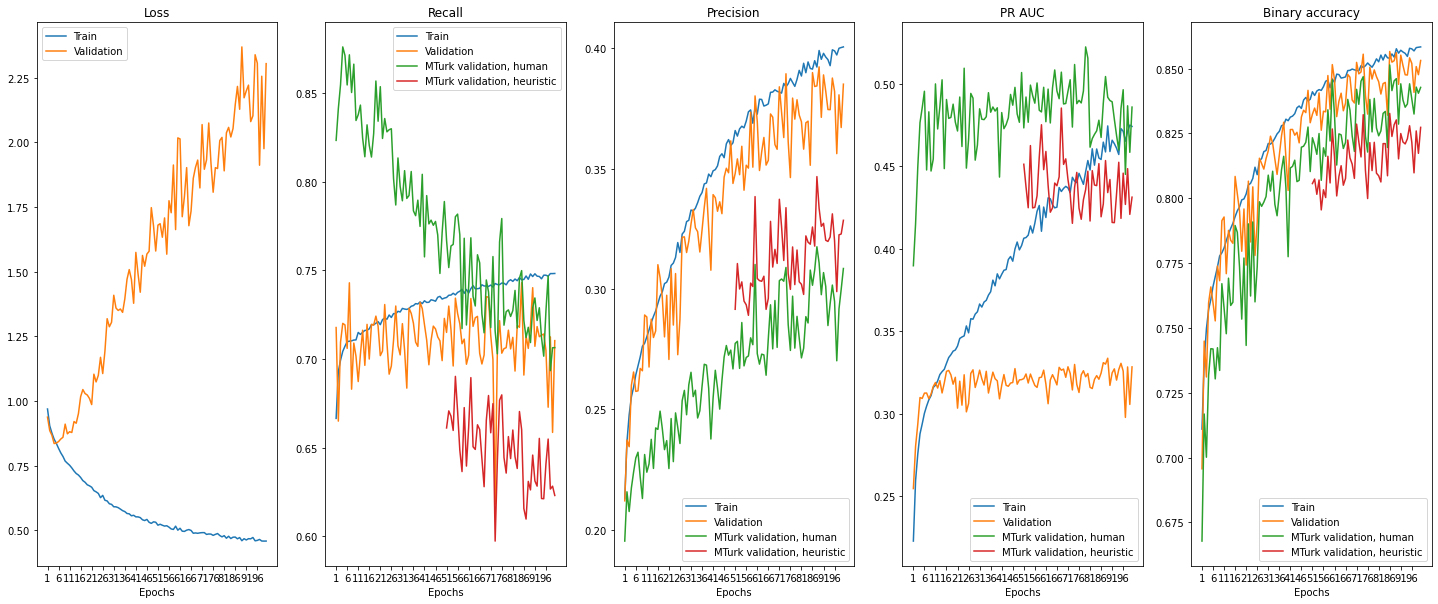

In [29]:
from matplotlib import pyplot as plt

training_metrics = pd.read_csv(config['results_folder'] + '/history.csv')

epochs = config['epochs']

plt.figure(figsize=(25,10))

_ = plt.subplot(1, 5, 1)
plt.plot(range(config['epochs']), training_metrics.loss.values, label='Training loss')
plt.plot(range(config['epochs']), training_metrics.val_loss.values, label='Validation loss')
# plt.plot(range(config['epochs']), model_metrics_on_human_labeled_data.loss, label='Loss against human-labeled data')
plt.xlabel('Epochs')
plt.title('Loss')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'Human validation'])

_ = plt.subplot(1, 5, 2)
plt.plot(range(config['epochs']), training_metrics.recall.values, label='Training recall')
plt.plot(range(config['epochs']), training_metrics.val_recall.values, label='Validation recall')
plt.plot(range(config['epochs']), human_labeled_data_metrics.recall, label='Recall against human-labeled data')
plt.plot(range(50, config['epochs']), model_metrics_on_human_labeled_data.recall, label='Recall against human-labeled data')
plt.title('Recall')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'MTurk validation, human', 'MTurk validation, heuristic'])

_ = plt.subplot(1, 5, 3)
plt.plot(range(config['epochs']), training_metrics.precision.values, label='Training precision')
plt.plot(range(config['epochs']), training_metrics.val_precision.values, label='Validation precision')
plt.plot(range(config['epochs']), human_labeled_data_metrics.precision, label='Recall against human-labeled data')
plt.plot(range(50, config['epochs']), model_metrics_on_human_labeled_data.precision, label='Recall against human-labeled data')
plt.title('Precision')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'MTurk validation, human', 'MTurk validation, heuristic'])

_ = plt.subplot(1, 5, 4)
plt.plot(range(config['epochs']), training_metrics.pr_auc.values, label='Training PR_AUC')
plt.plot(range(config['epochs']), training_metrics.val_pr_auc.values, label='Validation PR_AUC')
plt.plot(range(config['epochs']), human_labeled_data_metrics.pr_auc, label='PR_AUC against human-labeled data')
plt.plot(range(50, config['epochs']), model_metrics_on_human_labeled_data.pr_auc, label='PR_AUC against human-labeled data')
plt.title('PR AUC')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'MTurk validation, human', 'MTurk validation, heuristic'])

_ = plt.subplot(1, 5, 5)
plt.plot(range(config['epochs']), training_metrics.binary_accuracy.values, label='Training binary acc')
plt.plot(range(config['epochs']), training_metrics.val_binary_accuracy.values, label='Validation binary acc')
plt.plot(range(config['epochs']), human_labeled_data_metrics.accuracy, label='Recall against human-labeled data')
plt.plot(range(50, config['epochs']), model_metrics_on_human_labeled_data.accuracy, label='Recall against human-labeled data')
plt.title('Binary accuracy')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, config['epochs'], step=5), np.arange(1, config['epochs']+1, step=5))
plt.legend(['Train', 'Validation', 'MTurk validation, human', 'MTurk validation, heuristic'])

# hf.save_img(config['results_folder'] + '/training_metrics.png')

In [32]:
y_true_heuristics = hf.get_y_true(shape=(human_labeled_data_with_heuristic_labels.samples, len(human_labeled_data_with_heuristic_labels.class_indices)), classes=human_labeled_data_with_heuristic_labels.classes)

In [39]:
y_true_heuristics.sum() / y_true_heuristics.shape[0]

3.705263157894737

In [33]:
y_true_human = hf.get_y_true(shape=(human.samples, len(human.class_indices)), classes=human.classes)

In [38]:
y_true_human.sum() / y_true_human.shape[0]

2.431578947368421

In [41]:
y_pred.sum() / y_true_human.shape[0]

5.922807017543859